In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/input.zip -d /datalab/input

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2722.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2723.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2724.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2725.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2726.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2727.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2728.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2729.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2730.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2731.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2732.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2733.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2734.jpg  
  inflating: /datalab/input/NewMasksDataset/Test/Non Mask/2735.jpg 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
from IPython.display import display
import pandas as pd
import os

for dirname, _, filenames in os.walk('/datalab/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/datalab/input/NewMasksDataset/Test/Non Mask/2751.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2755.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2757.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2782.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2752.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2750.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2736.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2718.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2737.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2727.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2724.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2747.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2768.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2763.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2753.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2761.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2741.jpg
/datalab/input/NewMasksDataset/Test/Non Mask/2

In [ ]:
import cv2
import inspect
import keras
from tensorflow.keras import Sequential, applications
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import ceil
import matplotlib.pyplot as plt
import random
from timeit import default_timer as timer
from tqdm import tqdm

In [ ]:
# 마스크 착용된 사진들의 디렉토리 모음
with_mask_dirs = ['/datalab/input/FaceMaskDataset/Train/WithMask', 
                  '/datalab/input/FaceMaskDataset/Validation/WithMask',
                  '/datalab/input/FaceMaskDataset/Test/WithMask',
                  '/datalab/input/NewMasksDataset/Train/Mask',
                  '/datalab/input/NewMasksDataset/Validation/Mask',
                  '/datalab/input/NewMasksDataset/Test/Mask']
# 마스크 미착용된 사진들의 디렉토리 모음
without_mask_dirs = ['/datalab/input/FaceMaskDataset/Train/WithoutMask',
                     '/datalab/input/FaceMaskDataset/Validation/WithoutMask',
                     '/datalab/input/FaceMaskDataset/Test/WithoutMask',
                     '/datalab/input/NewMasksDataset/Train/Non Mask',
                     '/datalab/input/NewMasksDataset/Validation/Non Mask',
                     '/datalab/input/NewMasksDataset/Test/Non Mask']
# 마스크 오착용된 사진들의 디렉토리 모음
wrong_mask_dirs = ['/datalab/input/FaceMaskDataset/Train/WrongMask',
                     '/datalab/input/FaceMaskDataset/Validation/WrongMask',
                     '/datalab/input/FaceMaskDataset/Test/WrongMask',
                     '/datalab/input/NewMasksDataset/Train/WrongMask',
                     '/datalab/input/NewMasksDataset/Validation/WrongMask',
                     '/datalab/input/NewMasksDataset/Test/WrongMask']

                     

# 사진들의 디렉토리와 타겟 값을 dataframe으로 묶음
def folder_to_df(dirs, labels):
    file_list = []
    num_folders = len(dirs)
    print(num_folders)
    for count, folder in enumerate(dirs, start=1):
        for file in sorted(os.listdir(folder)):
            if count < num_folders/3:
                file_list.append((folder + '/' + file, labels[0]))
            elif count >= num_folders/3 and count < 2*(num_folders/3):
                file_list.append((folder + '/' + file, labels[1]))
            else:
                file_list.append((folder + '/' + file, labels[2]))
                
    return pd.DataFrame(file_list, columns=['filename', 'class'])

labels = ['With Mask', 'Without Mask', 'Wrong Mask'] # 타겟 값: 마스크 착용, 마스크 미착용, 마스크 오착용, 코스크
all_mask_df = folder_to_df(with_mask_dirs + without_mask_dirs + wrong_mask_dirs, labels) # 모든 사진들의 디렉토리를 dataframe으로 합침

shuffled_mask_df = all_mask_df.sample(frac=1) # 고른 선택을 위해 데이터 전체의 순서를 섞음

train_df, val_df, test_df = np.split(shuffled_mask_df, 
                                     [int(0.8*len(shuffled_mask_df)), int(0.9*len(shuffled_mask_df))]) # 데이터를 80:10:10의 비율로 train, validation, test 분할

# train, validation, test 세트 확인
print('total dataset : {}\ntraining set  : {}\nvalidation set: {}\ntest set      : {}'.format(all_mask_df.shape, train_df.shape, val_df.shape, test_df.shape))
display(train_df.head(5), val_df.head(5), test_df.head(5))


18
total dataset : (13566, 2)
training set  : (10852, 2)
validation set: (1357, 2)
test set      : (1357, 2)


,filename,class
7708,/datalab/input/FaceMaskDataset/Train/WrongMask...,Wrong Mask
7619,/datalab/input/FaceMaskDataset/Train/WrongMask...,Wrong Mask
8455,/datalab/input/FaceMaskDataset/Train/WrongMask...,Wrong Mask
8208,/datalab/input/FaceMaskDataset/Train/WrongMask...,Wrong Mask
24,/datalab/input/FaceMaskDataset/Train/WithMask/...,With Mask


,filename,class
4609,/datalab/input/FaceMaskDataset/Train/WithoutMa...,Without Mask
8700,/datalab/input/FaceMaskDataset/Validation/Wron...,Wrong Mask
8741,/datalab/input/FaceMaskDataset/Validation/Wron...,Wrong Mask
13154,/datalab/input/NewMasksDataset/Test/WrongMask/...,Wrong Mask
8001,/datalab/input/FaceMaskDataset/Train/WrongMask...,Wrong Mask


,filename,class
8599,/datalab/input/FaceMaskDataset/Validation/Wron...,Wrong Mask
6255,/datalab/input/FaceMaskDataset/Train/WrongMask...,Wrong Mask
11102,/datalab/input/NewMasksDataset/Train/WrongMask...,Wrong Mask
11377,/datalab/input/NewMasksDataset/Train/WrongMask...,Wrong Mask
2009,/datalab/input/FaceMaskDataset/Test/WithMask/A...,With Mask


In [ ]:
'''
# 마스크 착용된 사진들의 디렉토리 모음
with_mask_dirs = ['/content/drive/MyDrive/testset/mask']
# 마스크 미착용된 사진들의 디렉토리 모음
without_mask_dirs = ['/content/drive/MyDrive/testset/nonemask']
# 마스크 오착용된 사진들의 디렉토리 모음
wrong_mask_dirs = ['/content/drive/MyDrive/testset/wrongmask']
# 코스크 사진들의 디렉토리 모음
nose_mask_dirs = ['/content/drive/MyDrive/testset/nosemask']

                     

# 사진들의 디렉토리와 타겟 값을 dataframe으로 묶음
def folder_to_df(dirs, labels):
    file_list = []
    num_folders = len(dirs)
    print(num_folders)
    for count, folder in enumerate(dirs, start=1):
        for file in sorted(os.listdir(folder)):
            if count <= num_folders/4:
                file_list.append((folder + '/' + file, labels[0]))
            elif count > num_folders/4 and count <= 2*(num_folders/4):
                file_list.append((folder + '/' + file, labels[1]))
            elif count > 2*(num_folders/4) and count <= 3*(num_folders/4):
                file_list.append((folder + '/' + file, labels[2]))
            else:
                file_list.append((folder + '/' + file, labels[3]))
                
    return pd.DataFrame(file_list, columns=['filename', 'class'])

labels = ['With Mask', 'Without Mask', 'Wrong Mask', 'Nose Mask'] # 타겟 값: 마스크 착용, 마스크 미착용, 마스크 오착용, 코스크
all_mask_df = folder_to_df(with_mask_dirs + without_mask_dirs + wrong_mask_dirs + nose_mask_dirs, labels) # 모든 사진들의 디렉토리를 dataframe으로 합침

shuffled_mask_df = all_mask_df.sample(frac=1) # 고른 선택을 위해 데이터 전체의 순서를 섞음

test_df = shuffled_mask_df # 데이터를 80:10:10의 비율로 train, validation, test 분할

# train, validation, test 세트 확인
print('total dataset : {}\ntraining set  : {}\nvalidation set: {}\ntest set      : {}'.format(all_mask_df.shape, train_df.shape, val_df.shape, test_df.shape))
display(test_df.head(15))
'''


"\n# 마스크 착용된 사진들의 디렉토리 모음\nwith_mask_dirs = ['/content/drive/MyDrive/testset/mask']\n# 마스크 미착용된 사진들의 디렉토리 모음\nwithout_mask_dirs = ['/content/drive/MyDrive/testset/nonemask']\n# 마스크 오착용된 사진들의 디렉토리 모음\nwrong_mask_dirs = ['/content/drive/MyDrive/testset/wrongmask']\n# 코스크 사진들의 디렉토리 모음\nnose_mask_dirs = ['/content/drive/MyDrive/testset/nosemask']\n\n                     \n\n# 사진들의 디렉토리와 타겟 값을 dataframe으로 묶음\ndef folder_to_df(dirs, labels):\n    file_list = []\n    num_folders = len(dirs)\n    print(num_folders)\n    for count, folder in enumerate(dirs, start=1):\n        for file in sorted(os.listdir(folder)):\n            if count <= num_folders/4:\n                file_list.append((folder + '/' + file, labels[0]))\n            elif count > num_folders/4 and count <= 2*(num_folders/4):\n                file_list.append((folder + '/' + file, labels[1]))\n            elif count > 2*(num_folders/4) and count <= 3*(num_folders/4):\n                file_list.append((folder + '/' + file, labels

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=10, # 기울어진 얼굴
                                   zoom_range=0.1, # 확대된 얼굴
                                   horizontal_flip=True, # 좌우 반전된 얼굴
                                   rescale=1.0/255) # 255개의 RGB values에 맞춰서 축소

val_test_datagen = ImageDataGenerator(rescale=1.0/255) # validation

In [ ]:
VAL_BATCH_SIZE = 128
BATCH_SIZE = VAL_BATCH_SIZE * 8

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    target_size=(128,128), # 최대 입력 이미지 크기에 맞춤
    class_mode='categorical',
    batch_size=BATCH_SIZE) # 출력 값 2가지: 마스크 착용, 마스크 미착용
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=VAL_BATCH_SIZE)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=VAL_BATCH_SIZE)

Found 10852 validated image filenames belonging to 3 classes.
Found 1357 validated image filenames belonging to 3 classes.
Found 1357 validated image filenames belonging to 3 classes.


In [ ]:
def show_img_samples(dirs, num, label):
    folder = random.choice(dirs) # randomly choose folder
    images = random.sample(os.listdir(folder), num) # randomly choose img
    
    plt.figure(figsize=(20, 10))
    for i in range(num):
        plt.subplot(num // 5 + 1, 5, i + 1)
        img = cv2.cvtColor(cv2.imread(folder + '/' + images[i]), cv2.COLOR_BGR2RGB)
        plt.subplots_adjust(hspace=0.001)
        plt.xlabel(label)
        plt.imshow(img)
    plt.show()

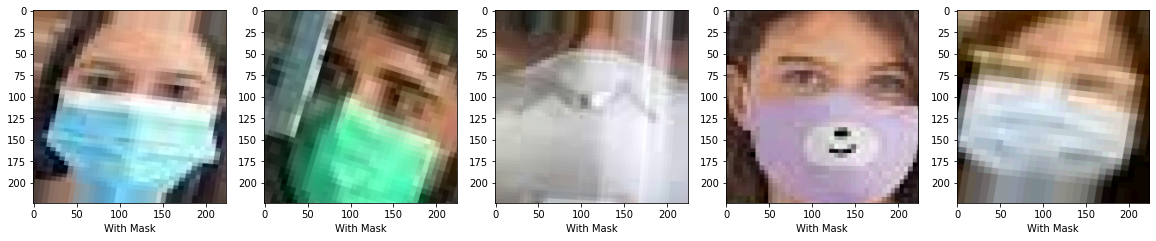

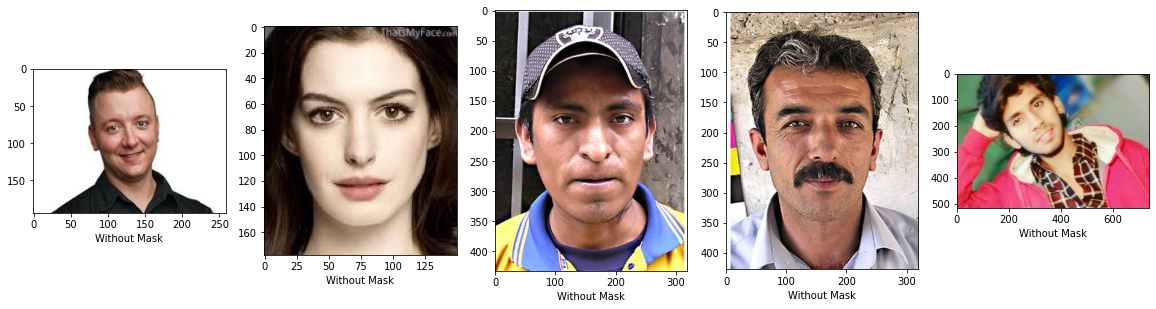

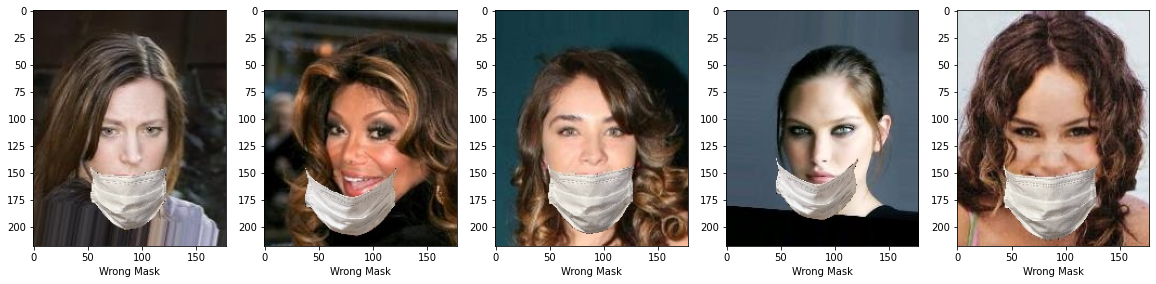

In [ ]:
show_img_samples(with_mask_dirs, 5, 'With Mask')
show_img_samples(without_mask_dirs, 5, 'Without Mask')
show_img_samples(wrong_mask_dirs, 5, 'Wrong Mask')

In [ ]:
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

In [ ]:
pretrained_base = applications.DenseNet121(
    include_top=False, # 128x128의 이미지 크기를 맞추기 위해 False로 설정
    input_shape=(128,128,3), # 이미지 크기와 RGB 값 갯수
    pooling='avg') 
pretrained_base.trainable = False

model = Sequential([
    pretrained_base,
    Flatten(),
    Dense(3, activation='softmax')])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0,
    patience=10, # 10번의 epoch 동안 val_loss이 더 이상 줄어들지 않을 때 훈련을 멈춤
    verbose=1,
    mode='min',
    restore_best_weights=True)

In [ ]:
EPOCHS = 150

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=val_generator)

Epoch 1/150
11/11 [==============================] - 141s 11s/step - loss: 0.9061 - accuracy: 0.6332 - val_loss: 0.6050 - val_accuracy: 0.7716
Epoch 2/150
11/11 [==============================] - 106s 9s/step - loss: 0.4720 - accuracy: 0.8238 - val_loss: 0.3675 - val_accuracy: 0.8629
Epoch 3/150
11/11 [==============================] - 105s 9s/step - loss: 0.3306 - accuracy: 0.8853 - val_loss: 0.2874 - val_accuracy: 0.9020
Epoch 4/150
11/11 [==============================] - 106s 10s/step - loss: 0.2650 - accuracy: 0.9099 - val_loss: 0.2368 - val_accuracy: 0.9241
Epoch 5/150
11/11 [==============================] - 106s 10s/step - loss: 0.2342 - accuracy: 0.9263 - val_loss: 0.2145 - val_accuracy: 0.9366
Epoch 6/150
11/11 [==============================] - 105s 9s/step - loss: 0.2111 - accuracy: 0.9314 - val_loss: 0.1972 - val_accuracy: 0.9447
Epoch 7/150
11/11 [==============================] - 105s 9s/step - loss: 0.1931 - accuracy: 0.9409 - val_loss: 0.1804 - val_accuracy: 0.9528
Epo

Minimum validation loss: 0.0956433042883873
Maximum validation accuracy: 0.9778923988342285


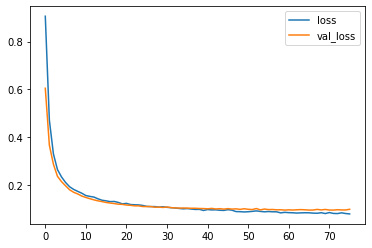

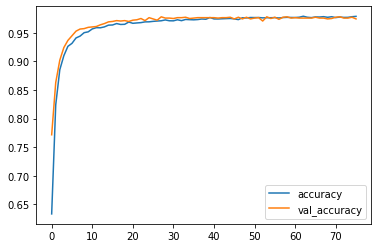

In [ ]:
history_df = pd.DataFrame(history.history)
history_df
history_df.loc[:, ['loss', 'val_loss']].plot();
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(test_generator)

11/11 [==============================] - 8s 701ms/step - loss: 0.0936 - accuracy: 0.9786


[0.09356385469436646, 0.9786293506622314]

In [ ]:
model.save('DenseNet121441113.h5')

In [ ]:
def predict_rand_sample(num, label):
    plt.figure(figsize=(20,10))
    img_dirs = test_df.loc[test_df['class'] == label].sample(num).values[:, 0] # 사진들을 임의로 선택
    for i in range(num):
        plt.subplot(num // 5 + 1, 5, i + 1)
        
        img = cv2.cvtColor(cv2.imread(img_dirs[i]), cv2.COLOR_BGR2RGB)
        processed_img = cv2.resize(img,(128,128))
        processed_img = np.reshape(processed_img,[1,128,128,3])
        processed_img = processed_img/255.0
        prediction = [model.predict(processed_img)[0][0], model.predict(processed_img)[0][1], model.predict(processed_img)[0][2]] # 사진의 결과값 에측
        if prediction[0] > prediction[1] and prediction[0] > prediction[2]:
            plt.xlabel('With Mask')
        elif prediction[1] > prediction[0] and prediction[1] > prediction[2]:
            plt.xlabel('Without Mask')
        else:
            plt.xlabel('Wrong Mask')
        plt.imshow(img)
    plt.show

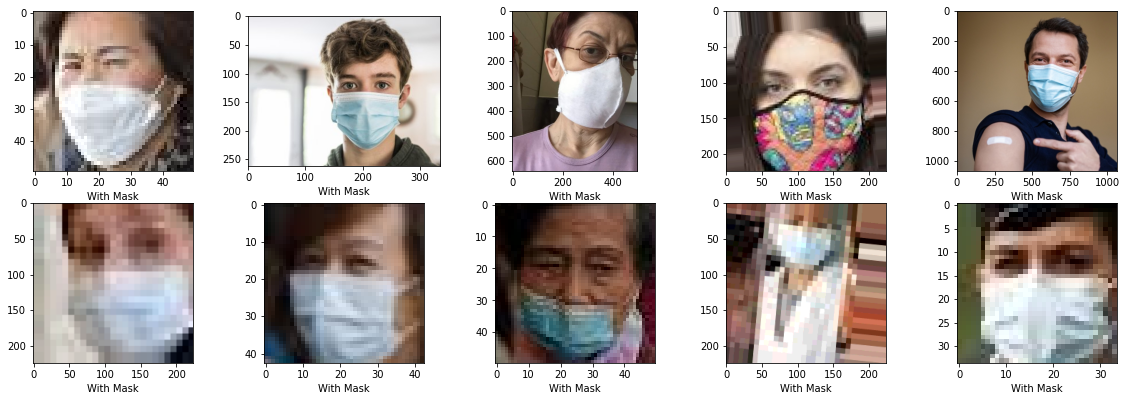

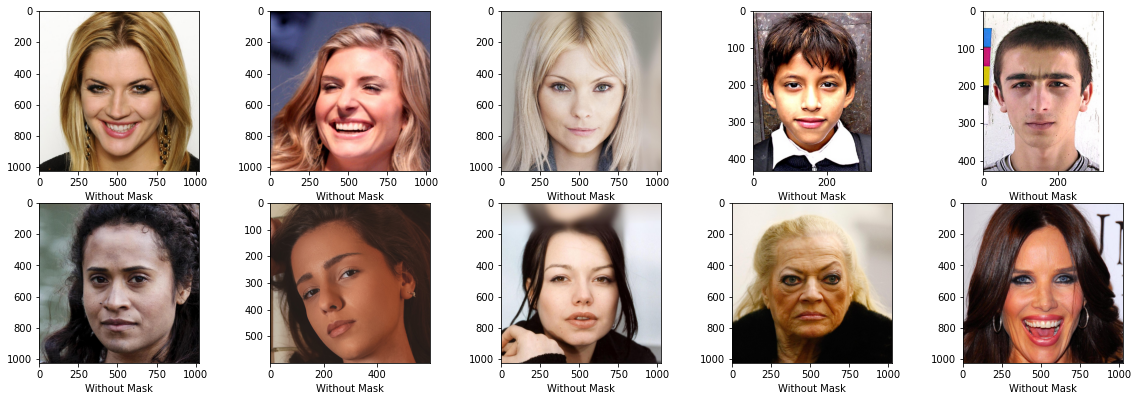

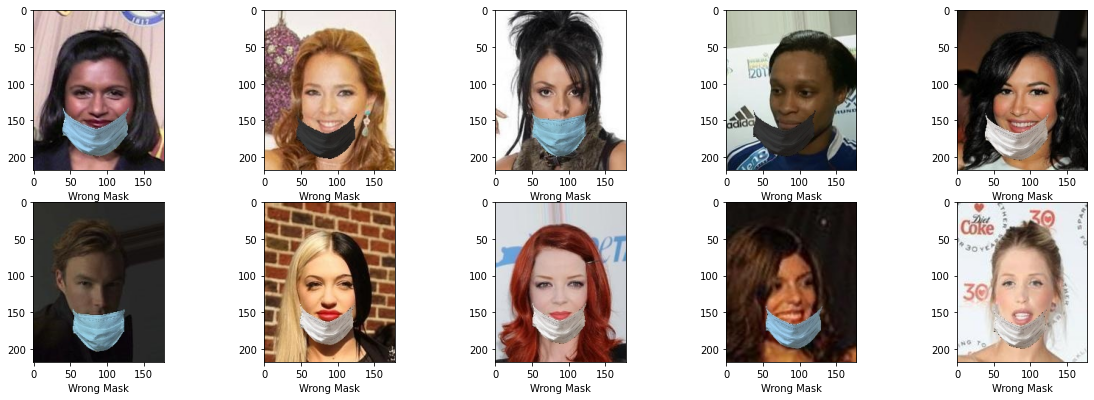

In [ ]:
predict_rand_sample(10, 'With Mask')
predict_rand_sample(10, 'Without Mask')
predict_rand_sample(10, 'Wrong Mask')

In [ ]:
model.save('/content/drive/MyDrive/Mask_12_1.h5')